In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# File and directory operations
import os

# Geospatial data processing and analysis
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import rioxarray
import xrspatial
from rasterio.enums import Resampling
import pyproj
import shapely.geometry as sg
from shapely.ops import transform

# Geospatial data access and catalogs
import pystac_client
import planetary_computer
import odc.stac

# Date and time manipulation
from datetime import datetime, timedelta
from time import time

# Progress tracking
from tqdm import tqdm

# Images
from PIL import Image
import requests
from io import BytesIO

c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\ygrin\anaconda3\envs\ADSthesis\Lib\site-packages\libpysal\cg\alpha_shape

In [2]:
# Test data
test_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/"
test_results_path = "C:/Users/ygrin/Documents/Studie - MSc ADS/Utrecht University/Block 4 - Thesis/TestData/Results/"
single_point = gpd.read_file(test_path + "Test_single_home_location.gpkg")
multi_point = gpd.read_file(test_path + "Test_multiple_home_locations.gpkg")
#polygon = gpd.read_file(test_path + "TestArea.gpkg")
ndvi = rioxarray.open_rasterio(test_path + "NDVI_data_test.tif")
land_cover = rioxarray.open_rasterio(test_path + "Landcover_data_test.tif")
#network = gpd.read_file(test_path + "test_network.gpkg", layer='edges')
network = gpd.read_file(test_path + "test_network_shp.shp")
polygon = gpd.read_file(test_path + "test_polygon.gpkg")
canopy_single = gpd.read_file(test_path + "Canopy_single_home_500m.gpkg")

single_point_geographic = single_point.to_crs('epsg:4326')

In [3]:
# Function to create isochrone polygon of network
def make_iso_poly(G, edge_buff=25, node_buff=0, center_node=None, trip_time=None):
    #Note: based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time") # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters

    node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # Create list of point geometries existing of x and y coordinates for each node in subgraph retrieved from previous step
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # Create geodataframe containing data from previous step
    nodes_gdf = nodes_gdf.set_index("id") # Set index to node ID

    edge_lines = []
    for n_fr, n_to in subgraph.edges(): # Iterate over edges in subgraph
        f = nodes_gdf.loc[n_fr].geometry # Retrieve geometry of the 'from' node of the edge
        t = nodes_gdf.loc[n_to].geometry # Retrieve geometry of the 'to' node of the edge
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t])) # Retrieve edge geometry between from and to nodes
        edge_lines.append(edge_lookup) # Append edge geometry to list of edge lines

    n = nodes_gdf.buffer(node_buff).geometry # Create buffer around the nodes
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry # Create buffer around the edges
    all_gs = list(n) + list(e) # Concatenate nodes and edges
    isochrone_poly = gpd.GeoSeries(all_gs).unary_union # Create polygon of the concatenated nodes and edges

    isochrone_poly = sg.Polygon(isochrone_poly.exterior) # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    
    return isochrone_poly

# Greenness Availability -- Mean NDVI

In [4]:
def get_mean_NDVI(point_of_interest_file, ndvi_raster_file=None, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                  buffer_dist=None, network_file=None, network_type=None, trip_time=None, travel_speed=None, year=datetime.now().year, 
                  write_to_file=True, save_ndvi=True, output_dir=os.getcwd()):
    ### Step 1: Read and process user inputs, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")
    
    # Make sure the type of polygon is specified if poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")

        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326") # Transformer to use planetary computer and OSM

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)

    # Retrieve NDVI raster, use planetary computer if not provided by user 
    if ndvi_raster_file is None:
        print("Retrieving NDVI raster through planetary computer...")
        start_ndvi_retrieval = time()
        bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds  # transform CRS to comply with planetary computer requirements
        bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] # Swap coords order to match with planetary computer format

        # Query planetary computer
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
        # Obtain Area of Interest
        time_of_interest = f"{year}-01-01/{year}-12-30" 
        # Search Data
        search = catalog.search(collections=["sentinel-2-l2a"],
                                bbox=bounding_box_pc,
                                datetime=time_of_interest,
                                query={"eo:cloud_cover": {"lt": 20}})
        # Obtain Data
        items = search.item_collection()
        items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
        items_df_poi = items_df[items_df.geometry.contains(sg.box(*bounding_box_pc))]
        lowest_cloud_cover = items_df_poi['eo:cloud_cover'].min()
        item_to_select = items_df_poi[items_df_poi['eo:cloud_cover'] == lowest_cloud_cover]
        selected_item = next(item for item in items if item.properties["s2:granule_id"] == item_to_select.iloc[0]['s2:granule_id'])

        # Obtain Bands of Interest
        selected_item_data = odc.stac.stac_load([selected_item], bands = ['red', 'green', 'blue', 'nir'], bbox = bounding_box_pc).isel(time=0)
        # Calculate NDVI values
        ndvi = xrspatial.multispectral.ndvi(selected_item_data['nir'], selected_item_data['red'])
        # Reproject to original poi CRS
        ndvi_src = ndvi.rio.reproject(f"EPSG:{epsg}", resampling= Resampling.nearest, nodata=np.nan)

        print(f"Information on the satellite image retrieved from planetary computer, use to calculate NDVI values:\
              \n   Date on which image was generated: {selected_item.properties['s2:generation_time']}\
              \n   Percentage of cloud cover: {selected_item.properties['eo:cloud_cover']}\
              \n   Percentage of pixels with missing data {selected_item.properties['s2:nodata_pixel_percentage']}")

        if save_ndvi:
            # Retrieve the image URL
            image_url = selected_item.assets["rendered_preview"].href
            # Download the image data
            response = requests.get(image_url)
            # Create a PIL Image object from the downloaded image data
            image = Image.open(BytesIO(response.content))
            # Save the image to a file
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
            image.save(os.path.join(output_dir, f"{input_filename}_ndvi_satellite_image.png"))
            print("NDVI satellite image successfully saved as image")
        end_ndvi_retrieval = time()
        elapsed_ndvi_retrieval = end_ndvi_retrieval - start_ndvi_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_ndvi_retrieval))} \n")
    else:
        ndvi_src = rioxarray.open_rasterio(ndvi_raster_file)
        if not ndvi_src.rio.crs.to_epsg() == epsg:
            print("Adjusting CRS of NDVI file to match with Point of Interest CRS...")
            ndvi_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the NDVI raster provided
        if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the NDVI file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*ndvi_src.rio.bounds())) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the NDVI file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the NDVI file provided, results will be based on intersecting part of polygons involved \n") 

    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            if not isinstance(travel_speed, int) or (not travel_speed > 0):
                raise TypeError("Please make sure that the travel speed is set as a positive integer")

            if not isinstance(trip_time, int) or (not trip_time > 0):
                raise TypeError("Please make sure that the trip time is set as a positive integer")

            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n")
                        
            if network_file is None:
                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                
                print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
                start_network_retrieval = time()
                polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") # Transform to 4326 for OSM
                wgs_polygon = polygon_gdf_wgs['geometry'].values[0] # Extract polygon in EPSG 4326        
                graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) # Retrieve street network for desired network type
                graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") # Project street network graph back to original poi CRS
                end_network_retrieval = time()
                elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
                print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")            

                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

                aoi_geometry = []
                for geom in tqdm(poi['geometry'], desc = 'Retrieving isochrone for point(s) of interest'):
                    center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) # Find node which is closest to point location as base for next steps
                    buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(buffer_graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
                print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")   
            else:
                if os.path.splitext(network_file)[1] not in [".gpkg", ".shp"]:
                    raise ValueError("Please provide the network file in '.gpkg' or '.shp' format")
                elif os.path.splitext(network_file)[1] == ".gpkg":
                    network = gpd.read_file(network_file, layer='edges')
                else:
                    network = gpd.read_file(network_file)

                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done \n")

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                    raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')            
    
    ### Step 3: Calculate mean NDVI values and write results to file
    print("Calculating mean NDVI values...")
    start_calc = time()
    if not all(geom.within(sg.box(*ndvi_src.rio.bounds())) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the NDVI raster, note that results will be based on the intersecting part of the buffer zone")
    poi['mean_NDVI'] = aoi_gdf.apply(lambda row: ndvi_src.rio.clip([row.geometry]).clip(min=0).mean().values.round(3), axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_ndvi_added.gpkg"), driver="GPKG")
        print("Done")
    
    return poi

In [5]:
mean_ndvi = get_mean_NDVI(point_of_interest_file=test_path + "Test_single_home_location.gpkg", ndvi_raster_file=test_path + "NDVI_data_test.tif",
                          buffer_dist=1500, buffer_type="network", travel_speed=15, trip_time=5, network_type='bike', output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:05.964832 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating mean NDVI values...
Done, running time: 0:00:00.137034 

Writing results to new geopackage file in specified directory...
Done


In [6]:
mean_ndvi

,id,geometry,mean_NDVI
0,1,POINT (387164.991 394443.414),0.163


In [7]:
mean_ndvi = get_mean_NDVI(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", buffer_dist=500, 
                          buffer_type="network", travel_speed=15, trip_time=5, network_type='bike', output_dir=test_results_path, year=2022)

Retrieving NDVI raster through planetary computer...
Information on the satellite image retrieved from planetary computer, use to calculate NDVI values:              
   Date on which image was generated: 2022-08-12T23:41:32.330818Z              
   Percentage of cloud cover: 0.003142              
   Percentage of pixels with missing data 0.000232
NDVI satellite image successfully saved as image
Done, running time: 0:00:11.253241 

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:10.532313 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating mean NDVI values...
Done, running time: 0:00:00.307971 

Writing results to new geopackage file in specified directory...
Done


In [8]:
mean_ndvi

,id,geometry,mean_NDVI
0,1,POINT (388644.249 392861.634),0.255
1,2,POINT (385981.911 393805.494),0.241
2,3,POINT (388631.230 395322.181),0.274


# Greenness Availability -- Land Cover Percentages

In [9]:
# define function to calculate land cover percentages for a single geometry
def calculate_landcover_percentages(landcover_src, geometry):
    clipped = landcover_src.rio.clip([geometry]).clip(min=0) # Clip landcover raster to area of interest
    unique, counts = np.unique(clipped.values, return_counts=True) # Count the occurrences of all unique raster values
    total = counts.sum() # Calculate total nr. of occurrences 
    percentages = {value: str((count / total * 100).round(3)) + "%" for value, count in zip(unique, counts)} # Calculate percentages for each class
    return percentages

In [10]:
def get_landcover_percentages(point_of_interest_file, landcover_raster_file=None, crs_epsg=None, polygon_type="neighbourhood",
                              buffer_type=None, buffer_dist=None, network_file=None, network_type=None, trip_time=None, travel_speed=None, 
                              write_to_file=True, save_lulc=True, output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")

    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")

        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)

    if landcover_raster_file is None:
        epsg_transformer = pyproj.Transformer.from_crs(f"epsg:{epsg}", "epsg:4326")
        print("Retrieving landcover class raster through planetary computer...")
        start_landcover_retrieval = time()
        bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds  # transform CRS to comply with planetary computer requirements
        bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] # Swap coords order to match with planetary computer format

        # Query planetary computer
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)

        search = catalog.search(
            collections=["esa-worldcover"],
            bbox=bounding_box_pc,
        )

        items = search.item_collection()
        selected_item = items[0]
        # Extract landcover classes and store in dictionary to use in later stage
        class_list = selected_item.assets["map"].extra_fields["classification:classes"]
        classmap = {
            c["value"]: c["description"]
            for c in class_list
        }

        landcover = rioxarray.open_rasterio(selected_item.assets["map"].href)
        landcover_clip = landcover.rio.clip_box(*bounding_box_pc)
        landcover_src = landcover_clip.rio.reproject(f"EPSG:{epsg}", resampling= Resampling.nearest)
        
        print(f"Information on the land cover image retrieved from planetary computer:\
              \n   Image description: {selected_item.properties['description']}\
              \n   Image timeframe: {selected_item.properties['start_datetime']} - {selected_item.properties['end_datetime']}")

        if save_lulc:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
            landcover_src.rio.to_raster(os.path.join(output_dir, f"{input_filename}_lulc_raster.tif"))
            print("Landcover image successfully saved to raster file")
        end_landcover_retrieval = time()
        elapsed_landcover_retrieval = end_landcover_retrieval - start_landcover_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_landcover_retrieval))} \n")
    else:    
        landcover_src = rioxarray.open_rasterio(landcover_raster_file)
        if not landcover_src.rio.crs.to_epsg() == epsg:
            print("Adjusting CRS of land cover file to match with Point of Interest CRS...")
            landcover_src.rio.write_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the NDVI raster provided
        if not all(geom.within(sg.box(*landcover_src.rio.bounds())) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the landcover file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*landcover_src.rio.bounds())) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the landcover file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the landcover file provided, results will be based on intersecting part of polygons involved \n")

    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            if not isinstance(travel_speed, int) or (not travel_speed > 0):
                raise TypeError("Please make sure that the travel speed is set as a positive integer")

            if not isinstance(trip_time, int) or (not trip_time > 0):
                raise TypeError("Please make sure that the trip time is set as a positive integer") 

            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n")  
                     
            if network_file is None:
                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")

                print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
                start_network_retrieval = time()
                polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") # Transform to 4326 for OSM
                wgs_polygon = polygon_gdf_wgs['geometry'].values[0] # Extract polygon in EPSG 4326        
                graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) # Retrieve street network for desired network type
                graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") # Project street network graph back to original poi CRS
                end_network_retrieval = time()
                elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
                print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")         

                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

                aoi_geometry = []
                for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                    center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) # Find node which is closest to point location as base for next steps
                    buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(buffer_graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
                print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")   
            else:
                if os.path.splitext(network_file)[1] not in [".gpkg", ".shp"]:
                    raise ValueError("Please provide the network file in '.gpkg' or '.shp' format")
                elif os.path.splitext(network_file)[1] == ".gpkg":
                    network = gpd.read_file(network_file, layer='edges')
                else:
                    network = gpd.read_file(network_file)
                
                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done \n")

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                    raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')

    ### Step 3: Perform calculations and write results to file
    print("Calculating landcover class percentages...")
    start_calc = time()
    if not all(geom.within(sg.box(*landcover_src.rio.bounds())) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the landcover raster, note that results will be based on the intersecting part of the buffer zone")
       
    # apply the function to each geometry in the GeoDataFrame and create a new Pandas Series
    landcover_percentages_series = aoi_gdf.geometry.apply(lambda x: pd.Series(calculate_landcover_percentages(landcover_src=landcover_src, geometry=x)))
    # rename the columns with the landcover class values
    if landcover_raster_file is None:
        landcover_percentages_series = landcover_percentages_series.rename(columns=lambda x: str(classmap.get(x, x)))
    else:
        landcover_percentages_series.columns = ["class_" + str(col) for col in landcover_percentages_series.columns]
    # concatenate the new series to the original dataframe
    poi = pd.concat([poi, landcover_percentages_series], axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_LCperc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [11]:
lc_perc = get_landcover_percentages(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg",
                                    landcover_raster_file=test_path + "Landcover_data_test.tif", buffer_dist=500, 
                                    buffer_type="network", travel_speed=15, trip_time=5, network_type='bike', output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:13.284757 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating landcover class percentages...
Done, running time: 0:00:00.307228 

Writing results to new geopackage file in specified directory...
Done


In [12]:
lc_perc

,id,geometry,class_0,class_1001,class_1002,class_1003,class_1004,class_1005,class_1101,class_1102,...,class_1404,class_1405,class_1501,class_2001,class_2003,class_2004,class_2005,class_1502,class_1503,class_1504
0,1,POINT (388644.249 392861.634),42.45%,11.798%,0.013%,1.689%,0.806%,2.553%,0.127%,0.025%,...,0.07%,0.159%,0.006%,0.057%,0.038%,0.032%,0.076%,NaN,NaN,NaN
1,2,POINT (385981.911 393805.494),46.145%,17.396%,0.009%,1.947%,0.928%,4.035%,1.236%,NaN,...,0.545%,3.311%,0.052%,0.298%,0.047%,0.071%,0.152%,0.005%,0.009%,0.005%
2,3,POINT (388631.230 395322.181),31.642%,14.042%,NaN,1.222%,1.754%,2.192%,0.719%,0.007%,...,0.668%,0.503%,NaN,0.18%,0.036%,0.115%,0.165%,NaN,NaN,NaN


In [13]:
lc_perc = get_landcover_percentages(point_of_interest_file=test_path + "Test_multiple_home_locations.gpkg", buffer_dist=500, 
                                    buffer_type="network", travel_speed=15, trip_time=5, network_type='bike', output_dir=test_results_path)

Retrieving landcover class raster through planetary computer...
Information on the land cover image retrieved from planetary computer:              
   Image description: ESA WorldCover product at 10m resolution              
   Image timeframe: 2021-01-01T00:00:00Z - 2021-12-31T23:59:59Z
Landcover image successfully saved to raster file
Done, running time: 0:00:04.517424 

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:09.268179 



Retrieving isochrone for point(s) of interest: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating landcover class percentages...
Done, running time: 0:00:00.375656 

Writing results to new geopackage file in specified directory...
Done


In [14]:
lc_perc

,id,geometry,0,Tree cover,Grassland,Built-up,Bare / sparse vegetation
0,1,POINT (388644.249 392861.634),42.735%,16.121%,2.866%,38.275%,0.003%
1,2,POINT (385981.911 393805.494),46.059%,16.766%,2.056%,35.119%,NaN
2,3,POINT (388631.230 395322.181),30.251%,16.714%,11.373%,41.656%,0.006%


# Greenness Availability -- Canopy Coverage

In [15]:
def get_canopy_percentage(point_of_interest_file, canopy_vector_file, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                          buffer_dist=None, network_file=None, network_type=None, trip_time=None, travel_speed=None, write_to_file=True, 
                          output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")

    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")

        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)

    # Retrieve tree canopy data
    canopy_src = gpd.read_file(canopy_vector_file)
    if not (canopy_src['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']).all()):
        raise ValueError("Please make sure all geometries of the tree canopy file are of 'Polygon' or 'MultiPolygon' type and re-run the function")

    if not canopy_src.crs.to_epsg() == epsg:
        print("Adjusting CRS of Greenspace file to match with Point of Interest CRS...")
        canopy_src.to_crs(f'EPSG:{epsg}', inplace=True)
        print("Done \n")

    # Make sure all points of interest are within or do at least intersect (in case of polygons) the tree canopy file provided
    if not all(geom.within(sg.box(*canopy_src.total_bounds)) for geom in poi['geometry']):
        if geom_type == "Point":
            raise ValueError("Not all points of interest are within the tree canopy file provided, please make sure they are and re-run the function")
        else:
            if not all(geom.intersects(sg.box(*canopy_src.total_bounds)) for geom in poi['geometry']):
                raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the tree canopy file provided, please make sure they are/do and re-run the function")
            else:
                print("Warning: Not all polygons of interest are completely within the area covered by the tree canopy file provided, results will be based on intersecting part of polygons involved \n")

    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)
    
    ### Step 2: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:            
            if not isinstance(travel_speed, int) or (not travel_speed > 0):
                raise TypeError("Please make sure that the travel speed is set as a positive integer")

            if not isinstance(trip_time, int) or (not trip_time > 0):
                raise TypeError("Please make sure that the trip time is set as a positive integer") 
            
            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrone can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n") 
             
            if network_file is None:
                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                
                print("Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...")
                start_network_retrieval = time()
                polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") # Transform to 4326 for OSM
                wgs_polygon = polygon_gdf_wgs['geometry'].values[0] # Extract polygon in EPSG 4326        
                graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) # Retrieve street network for desired network type
                graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") # Project street network graph back to original poi CRS
                end_network_retrieval = time()
                elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
                print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")
                    
                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

                aoi_geometry = []
                for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                    center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) # Find node which is closest to point location as base for next steps
                    buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(buffer_graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
                print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")    
            else:
                if os.path.splitext(network_file)[1] not in [".gpkg", ".shp"]:
                    raise ValueError("Please provide the network file in '.gpkg' or '.shp' format")
                elif os.path.splitext(network_file)[1] == ".gpkg":
                    network = gpd.read_file(network_file, layer='edges')
                else:
                    network = gpd.read_file(network_file)

                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done \n")  

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                    raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')

    ### Step 3: Perform calculations and write results to file
    print("Calculating percentage of tree canopy coverage...")
    start_calc = time()
    if not all(geom.within(sg.box(*canopy_src.total_bounds)) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the tree canopy file, note that results will be based on the intersecting part of the buffer zone")

    # Calculate percentage of tree canopy cover   
    poi['canopy_cover'] = aoi_gdf.apply(lambda row: str(((canopy_src.clip(row.geometry).area.sum()/row.geometry.area)*100).round(2))+'%', axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_CanopyPerc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [16]:
canopy_perc = get_canopy_percentage(point_of_interest_file=test_path + "Test_single_home_location.gpkg",
                                    canopy_vector_file=test_path + "Canopy_single_home_500m.gpkg", buffer_dist=500, buffer_type="network",
                                    network_type='walk', trip_time=5, travel_speed=5, output_dir=test_results_path)

Retrieving network within total bounds of point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:09.931845 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating percentage of tree canopy coverage...
Done, running time: 0:00:00.559656 

Writing results to new geopackage file in specified directory...
Done


In [17]:
canopy_perc

,id,geometry,canopy_cover
0,1,POINT (387164.991 394443.414),24.03%


# Greenness Availability -- Park Coverage

In [18]:
def get_park_percentage(point_of_interest_file, park_vector_file=None, crs_epsg=None, polygon_type="neighbourhood", buffer_type=None, 
                        buffer_dist=None, network_file=None, network_type=None, trip_time=None, travel_speed=None, write_to_file=True, 
                        output_dir=os.getcwd()):
    ### Step 1: Read and process user input, check conditions
    poi = gpd.read_file(point_of_interest_file)
    if all(poi['geometry'].geom_type == 'Point') or all(poi['geometry'].geom_type == 'Polygon'):
        geom_type = poi.iloc[0]['geometry'].geom_type
    else:
        raise ValueError("Please make sure all geometries are of 'Point' type or all geometries are of 'Polygon' type and re-run the function")
    
    # Make sure type of polygon is specified in case poi file contains polygon geometries
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise ValueError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")

    # In case of house polygons, transform to centroids
    if geom_type == "Polygon":
        if polygon_type not in ["neighbourhood", "house"]:
            raise TypeError("Please make sure that the polygon_type argument is set to either 'neighbourhood' or 'house'")
        if polygon_type == "house":
            print("Changing geometry type to Point by computing polygon centroids...")
            poi['geometry'] = poi['geometry'].centroid
            geom_type = poi.iloc[0]['geometry'].geom_type
            print("Done \n")

    # Make sure buffer distance and type are set in case of point geometries
    if geom_type == "Point":
        if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
            raise TypeError("Please make sure that the buffer_dist argument is set to a positive integer")

        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

    # Make sure CRS is projected rather than geographic
    if not poi.crs.is_projected:
        if crs_epsg is None:
            print("Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to CRS with EPSG:3395")
            epsg = 3395
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
        else:
            print(f"Warning: The CRS of the PoI dataset is currently geographic, therefore it will now be projected to EPSG:{crs_epsg} as specified")
            epsg = crs_epsg
            poi.to_crs(f"EPSG:{epsg}", inplace=True)
    else:
        epsg = poi.crs.to_epsg()

    # Make sure poi dataframe contains ID column
    if "id" in poi.columns:
        if poi['id'].isnull().values.any():
            poi['id'] = poi['id'].fillna(pd.Series(range(1, len(poi) + 1))).astype(int)
    else:
        poi['id'] = pd.Series(range(1, len(poi) + 1)).astype(int)
    
    # Create polygon in which all pois are located to extract data from PC/OSM, incl. buffer if specified
    if buffer_dist is None:
        poi_polygon = sg.box(*poi.total_bounds)
    else:
        poi_polygon = sg.box(*poi.total_bounds).buffer(buffer_dist)
    polygon_gdf_wgs = gpd.GeoDataFrame(geometry=[poi_polygon], crs=f"EPSG:{epsg}").to_crs("EPSG:4326") # Transform to 4326 for OSM
    wgs_polygon = polygon_gdf_wgs['geometry'].values[0] # Extract polygon in EPSG 4326 

    ### Step 2: Read park data, retrieve from OSM if not provided by user
    if park_vector_file is None:
        print(f"Retrieving parks within total bounds of {geom_type}(s) of interest, extended by buffer distance if specified...")
        start_park_retrieval = time()
        # Tags seen as Urban Greenspace (UGS) require the following:
        # 1. Tag represent an area
        # 2. The area is outdoor
        # 3. The area is (semi-)publically available
        # 4. The area is likely to contain trees, grass and/or greenery
        # 5. The area can reasonable be used for walking or recreational activities
        park_tags = {'landuse':['allotments','forest','greenfield','village_green'], 'leisure':['garden','fitness_station','nature_reserve','park','playground'],'natural':'grassland'}
        park_src = ox.geometries_from_polygon(wgs_polygon, tags=park_tags)
        park_src.to_crs(f"EPSG:{epsg}", inplace=True)
        end_park_retrieval = time()
        elapsed_park_retrieval = end_park_retrieval - start_park_retrieval
        print(f"Done, running time: {str(timedelta(seconds=elapsed_park_retrieval))} \n")
    else:
        park_src = gpd.read_file(park_vector_file)
        if not (park_src['geometry'].geom_type.isin(['Polygon', 'MultiPolygon']).all()):
            raise ValueError("Please make sure all geometries of the park file are of 'Polygon' or 'MultiPolygon' type and re-run the function")
        
        if not park_src.crs.to_epsg() == epsg:
            print("Adjusting CRS of Greenspace file to match with Point of Interest CRS...")
            park_src.to_crs(f'EPSG:{epsg}', inplace=True)
            print("Done \n")

        # Make sure all points of interest are within or do at least intersect (in case of polygons) the park file provided
        if not all(geom.within(sg.box(*park_src.total_bounds)) for geom in poi['geometry']):
            if geom_type == "Point":
                raise ValueError("Not all points of interest are within the park file provided, please make sure they are and re-run the function")
            else:
                if not all(geom.intersects(sg.box(*park_src.total_bounds)) for geom in poi['geometry']):
                    raise ValueError("Not all polygons of interest are within, or do at least partly intersect, with the area covered by the park file provided, please make sure they are/do and re-run the function")
                else:
                    print("Warning: Not all polygons of interest are completely within the area covered by the park file provided, results will be based on intersecting part of polygons involved \n")

    ### Step 3: Construct the Area of Interest based on the arguments as defined by user
    if buffer_type is None:
        aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'])
    else:
        if buffer_type not in ["euclidian", "network"]:
            raise ValueError("Please make sure that the buffer_type argument is set to either 'euclidian' or 'network' and re-run the function")

        if buffer_type == "euclidian":
            if not isinstance(buffer_dist, int) or (not buffer_dist > 0):
                raise TypeError("Please make sure that the buffer distance is set as a positive integer")             

            aoi_gdf = gpd.GeoDataFrame(geometry=poi['geometry'].buffer(buffer_dist))
        else:
            if not isinstance(travel_speed, int) or (not travel_speed > 0):
                raise TypeError("Please make sure that the travel speed is set as a positive integer")

            if not isinstance(trip_time, int) or (not trip_time > 0):
                raise TypeError("Please make sure that the trip time is set as a positive integer")

            if geom_type == "Polygon":
                print("Changing geometry type to Point by computing polygon centroids so that isochrones can be retrieved...")
                poi['geometry'] = poi['geometry'].centroid
                print("Done \n") 
            
            if network_file is None:
                if network_type not in ["walk", "bike", "drive", "all"]:
                    raise ValueError("Please make sure that the network_type argument is set to either 'walk', 'bike, 'drive' or 'all', and re-run the function")
                
                print(f"Retrieving network within total bounds of {geom_type}(s) of interest, extended by buffer distance as specified...")
                start_network_retrieval = time()       
                graph = ox.graph_from_polygon(wgs_polygon, network_type=network_type) # Retrieve street network for desired network type
                graph_projected = ox.project_graph(graph, to_crs=f"EPSG:{epsg}") # Project street network graph back to original poi CRS
                end_network_retrieval = time()
                elapsed_network_retrieval = end_network_retrieval - start_network_retrieval
                print(f"Done, running time: {str(timedelta(seconds=elapsed_network_retrieval))} \n")
                    
                meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

                aoi_geometry = []
                for geom in tqdm(poi['geometry'], desc='Retrieving isochrone for point(s) of interest'):
                    center_node = ox.distance.nearest_nodes(graph_projected, geom.x, geom.y) # Find node which is closest to point location as base for next steps
                    buffer_graph = nx.ego_graph(graph_projected, center_node, radius=buffer_dist*2, distance="length")
                    for _, _, _, data in buffer_graph.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
                        data["time"] = data["length"] / meters_per_minute
                    isochrone_poly = make_iso_poly(buffer_graph, center_node=center_node, trip_time=trip_time) # See separate function for line by line explanation
                    aoi_geometry.append(isochrone_poly)

                aoi_gdf = gpd.GeoDataFrame(geometry=aoi_geometry, crs=f"EPSG:{epsg}")
                print("Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb \n")  
            else:
                if os.path.splitext(network_file)[1] not in [".gpkg", ".shp"]:
                    raise ValueError("Please provide the network file in '.gpkg' or '.shp' format")
                elif os.path.splitext(network_file)[1] == ".gpkg":
                    network = gpd.read_file(network_file, layer='edges')
                else:
                    network = gpd.read_file(network_file)

                if not network.crs.to_epsg() == epsg:
                    print("Adjusting CRS of Network file to match with Point of Interest CRS...")
                    network.to_crs(f'EPSG:{epsg}', inplace=True)
                    print("Done \n")  

                # Create bounding box for network file
                bbox_network = network.unary_union.convex_hull

                if not all(geom.within(bbox_network) for geom in poi['geometry']):
                    raise ValueError("Not all points of interest are within the network file provided, please make sure they are and re-run the function")

                aoi_gdf = gpd.GeoDataFrame(geometry=[bbox_network], crs=f'EPSG:{epsg}')

    ### Step 4: Perform calculations and write results to file
    print("Calculating percentage of park area coverage...")
    start_calc = time()
    if not all(geom.within(sg.box(*park_src.total_bounds)) for geom in aoi_gdf['geometry']):
        print(f"Warning: Not all buffer zones for the {geom_type}s of Interest are completely within the area covered by the park file, note that results will be based on the intersecting part of the buffer zone")

    # Calculate percentage of park area cover   
    poi['park_cover'] = aoi_gdf.apply(lambda row: str(((park_src.clip(row.geometry).area.sum()/row.geometry.area)*100).round(2))+'%', axis=1)
    end_calc = time()
    elapsed_calc = end_calc - start_calc
    print(f"Done, running time: {str(timedelta(seconds=elapsed_calc))} \n")

    if write_to_file:
        print("Writing results to new geopackage file in specified directory...")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        input_filename, _ = os.path.splitext(os.path.basename(point_of_interest_file))
        poi.to_file(os.path.join(output_dir, f"{input_filename}_ParkPerc_added.gpkg"), driver="GPKG")
        print("Done")

    return poi

In [19]:
park_perc = get_park_percentage(point_of_interest_file=test_path + "Test_single_home_location.gpkg",
                                buffer_dist=500, buffer_type="network", network_type='walk', trip_time=15, travel_speed=5, 
                                output_dir=test_results_path)

Retrieving parks within total bounds of Point(s) of interest, extended by buffer distance if specified...
Done, running time: 0:00:04.376580 

Retrieving network within total bounds of Point(s) of interest, extended by buffer distance as specified...
Done, running time: 0:00:02.111729 



Retrieving isochrone for point(s) of interest: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Note: creation of isochrones based on code by gboeing, source: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb 

Calculating percentage of park area coverage...
Done, running time: 0:00:00.034188 

Writing results to new geopackage file in specified directory...
Done


In [20]:
park_perc

,id,geometry,park_cover
0,1,POINT (387164.991 394443.414),0.86%


# User provided Network to Graph testing

In [ ]:
network_gpkg = gpd.read_file(test_path + "test_network.gpkg", layer='edges').to_crs("EPSG:27700")
network_shp = gpd.read_file(test_path + "test_network_shp.shp").to_crs("EPSG:27700")
test = momepy.gdf_to_nx(network_gpkg).to_directed()
test_2 = momepy.gdf_to_nx(network_shp).to_directed()

In [ ]:
nodes, edges = momepy.nx_to_gdf(test, points=True, lines=True)
x, y = nodes["geometry"].unary_union.centroid.xy # Calculate centroid of node geometries 
center_node = ox.distance.nearest_nodes(test, x[0], y[0]) # Find node which is closest to centroid as base for next steps
#graph = ox.project_graph(test) # Project street network graph back to original poi CRS
#graph_epsg = graph.graph['crs'].to_epsg() # Store EPSG code used for previous step
#for _, _, _, data in test.edges(data=True, keys=True): # Calculate the time it takes to cover each edge's distance
#    data["time"] = data["length"] / 250
#isochrone_poly = make_iso_poly(test, center_node=center_node, trip_time=15) # See separate function for line by line explanation
subgraph = nx.ego_graph(test, center_node, radius=15, distance="time") # Create sub graph of the street network which contains only parts which can be reached within specified travel parameters

node_points = [sg.Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # Create list of point geometries existing of x and y coordinates for each node in subgraph retrieved from previous step
nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points) # Create geodataframe containing data from previous step
nodes_gdf = nodes_gdf.set_index("id") # Set index to node ID

edge_lines = []
for n_fr, n_to in subgraph.edges(): # Iterate over edges in subgraph
    f = nodes_gdf.loc[n_fr].geometry # Retrieve geometry of the 'from' node of the edge
    t = nodes_gdf.loc[n_to].geometry # Retrieve geometry of the 'to' node of the edge
    edge_lookup = test.get_edge_data(n_fr, n_to)[0].get("geometry", sg.LineString([f, t])) # Retrieve edge geometry between from and to nodes
    edge_lines.append(edge_lookup) # Append edge geometry to list of edge lines

n = nodes_gdf.buffer(0).geometry # Create buffer around the nodes
e = gpd.GeoSeries(edge_lines).buffer(25).geometry # Create buffer around the edges
all_gs = list(n) + list(e) # Concatenate nodes and edges
isochrone_poly = gpd.GeoSeries(all_gs).unary_union # Create polygon of the concatenated nodes and edges

isochrone_poly = sg.Polygon(isochrone_poly.exterior) # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them

TypeError: Must pass list-like as `names`.

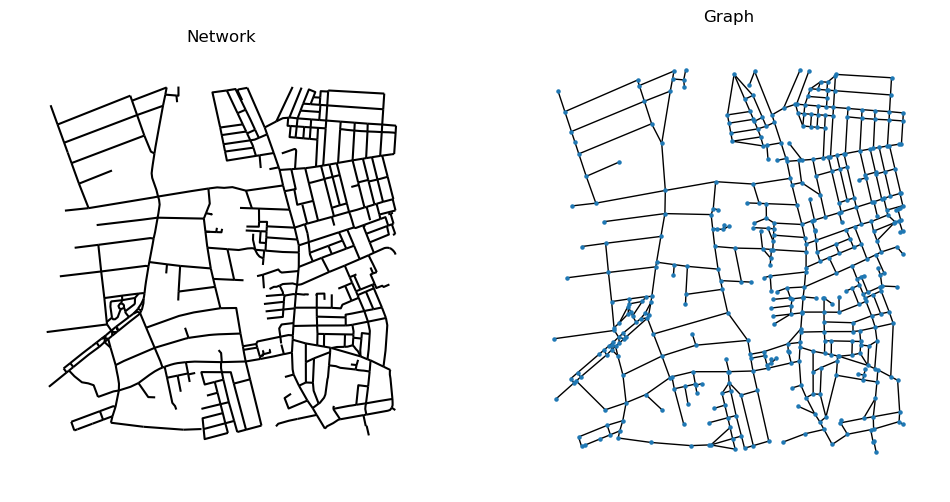

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

positions = {n: [n[0], n[1]] for n in list(test.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
network_gpkg.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Network", "Graph")[i])
    facet.axis("off")
nx.draw(test, positions, ax=ax[1], node_size=5)

In [98]:
from PIL import Image
import requests
from io import BytesIO

epsg_transformer = pyproj.Transformer.from_crs("epsg:28992", "epsg:4326") # Transformer to use planetary computer and OSM
epsg_transformer2 = pyproj.Transformer.from_crs("epsg:28992", "epsg:32631") # Transformer to use planetary computer and OSM
ams_points = gpd.read_file(test_path + "three_schools.geojson")
poi_polygon = sg.box(*ams_points.total_bounds)
bounding_box_pc = transform(epsg_transformer.transform, poi_polygon).bounds  # transform CRS to comply with planetary computer requirements
bounding_box_pc = [bounding_box_pc[1], bounding_box_pc[0], bounding_box_pc[3], bounding_box_pc[2]] # Swap coords order to match with planetary computer format

# Query planetary computer
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
# Obtain Area of Interest
time_of_interest = "2023-01-01/2023-12-30" 
# Search Data
search = catalog.search(collections=["esa-worldcover"],
                        bbox=bounding_box_pc,
                        datetime=time_of_interest,
                        query={"eo:cloud_cover": {"lt": 20}})
# Obtain Data
items = search.item_collection()
items_df = gpd.GeoDataFrame.from_features(items.to_dict())
#items_df_poi = items_df[items_df.geometry.contains(sg.box(*bounding_box_pc))]
#lowest_cloud_cover = items_df_poi['eo:cloud_cover'].min()
#item_to_select = items_df_poi[items_df_poi['eo:cloud_cover'] == lowest_cloud_cover]
#selected_item = next(item for item in items if item.properties["s2:granule_id"] == item_to_select.iloc[0]['s2:granule_id'])

# Retrieve the image URL
#image_url = selected_item.assets["rendered_preview"].href

# Download the image data
#response = requests.get(image_url)

# Create a PIL Image object from the downloaded image data
#image = Image.open(BytesIO(response.content))

# Save the image to a file
#image.save("output.png")

In [92]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)